# импорты

In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                           davies_bouldin_score, adjusted_rand_score)
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
import os
from collections import defaultdict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# импорт данных

In [4]:
def load_and_preprocess_data(file_path: str) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Load and preprocess the economic indicators dataset
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Get economic indicator columns
    indicator_cols = [col for col in df.columns 
                     if col not in ['country', 'year', 'has_platform']]
    
    # Print basic info for debugging
    print(f"Total columns: {len(df.columns)}")
    print(f"Economic indicators: {len(indicator_cols)}")
    print(f"Time range: {df['year'].min()} - {df['year'].max()}")
    print(f"Number of countries: {df['country'].nunique()}")
    
    # Handle missing values
    df[indicator_cols] = df[indicator_cols].fillna(method='ffill').fillna(method='bfill')
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[indicator_cols])
    
    return df, scaled_data

# создание классов с архитектурами моделей

## Economic2Vec

In [5]:
class Economic2Vec(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int):
        super(Economic2Vec, self).__init__()
        # Replace embedding with linear layers for continuous input
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(embedding_dim * 2, embedding_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(embedding_dim * 2, input_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, window_size, input_dim)
        batch_size, window_size, input_dim = x.shape
        
        # Reshape to process all windows together
        x_reshaped = x.reshape(-1, input_dim)  # (batch_size * window_size, input_dim)
        
        # Encode and decode
        encoded = self.encoder(x_reshaped)
        decoded = self.decoder(encoded)
        
        # Reshape back
        decoded = decoded.reshape(batch_size, window_size, input_dim)
        
        return decoded
    
    def get_embeddings(self, x: torch.Tensor) -> np.ndarray:
        with torch.no_grad():
            return self.encoder(x).detach().numpy()

## economic dataset

In [6]:
class EconomicDataset(Dataset):
    def __init__(self, data: np.ndarray, window_size: int = 5):
        self.data = torch.FloatTensor(data)
        self.window_size = window_size
    
    def __len__(self) -> int:
        return len(self.data) - self.window_size + 1
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        window = self.data[idx:idx + self.window_size]
        return window, window  # Same window for input and target

## обучение economic2vec

In [7]:
def train_economic2vec(data: np.ndarray, 
                      embedding_dim: int = 128, 
                      epochs: int = 100,
                      batch_size: int = 32,
                      window_size: int = 5) -> Economic2Vec:
    """
    Train Economic2Vec model with continuous input
    """
    dataset = EconomicDataset(data, window_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = Economic2Vec(data.shape[1], embedding_dim)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_windows, _ in dataloader:
            optimizer.zero_grad()
            output = model(batch_windows)
            # Use the last window output for prediction
            loss = criterion(output, batch_windows)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        losses.append(epoch_loss / len(dataloader))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]:.4f}')
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Economic2Vec Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model

# оценка и сравнение

## матрица близости

In [8]:
def compute_similarity_matrix(embeddings: np.ndarray) -> np.ndarray:
    """Compute cosine similarity matrix with handling edge cases"""
    sim_matrix = 1 - cdist(embeddings, embeddings, metric='cosine')
    return np.nan_to_num(sim_matrix, nan=0.0)  # Convert NaN to 0 for stability

## создание кластеров

In [9]:
def perform_kmeans_analysis(embeddings, 
                          countries,
                          n_clusters: int = 8) -> Tuple[np.ndarray, KMeans, np.ndarray]:
    """Process country embeddings and perform clustering"""
    # Calculate country embeddings
    unique_countries = np.unique(countries)
    country_embeddings = np.zeros((len(unique_countries), embeddings.shape[1]))
    
    for i, country in enumerate(unique_countries):
        mask = countries == country
        country_embeddings[i] = np.mean(embeddings[mask], axis=0)
    
    # Perform K-means clustering
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans_model.fit_predict(country_embeddings)
    
    return cluster_labels, kmeans_model, country_embeddings

## оценка эмбедингов

In [10]:
def evaluate_embeddings(
    original_data: np.ndarray,
    embeddings: np.ndarray,
    similarity_matrix: np.ndarray,
    method_name: str,
    countries: np.ndarray,
    n_clusters: int = 8,
    pca_model: PCA = None,
    reconstructed_data: np.ndarray = None
) -> Dict[str, Any]:
    
    # Perform clustering
    kmeans = KMeans(n_clusters=min(n_clusters, len(embeddings)), random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    results = {
        'method': method_name,
        'silhouette': silhouette_score(embeddings, clusters),
        'calinski': calinski_harabasz_score(embeddings, clusters),
        'davies': davies_bouldin_score(embeddings, clusters),
        'similarity_mean': np.mean(similarity_matrix),
        'similarity_std': np.std(similarity_matrix),
        'similarity_sparsity': np.mean(similarity_matrix > 0.5)
    }

    if method_name in ['PCA', 'Autoencoder']:
        data_to_compare = pca_model.inverse_transform(embeddings) if method_name == 'PCA' else reconstructed_data
        results['reconstruction_error'] = np.mean((original_data - data_to_compare) ** 2)
        
    return results

# пайплайн

## выполнение пайплайна

In [11]:
def run_analysis_pipeline(df: pd.DataFrame, 
                        scaled_data: np.ndarray,
                        embedding_dim: int = 128) -> Tuple[Dict[str, Any], Dict[str, np.ndarray], Dict[str, Dict]]:
    """Run complete analysis pipeline with all methods"""
    results = {}
    similarity_matrices = {}
    models_data = {}  # Store models, embeddings, labels for each method
    
    # 1. PCA
    print("Running PCA...")
    pca = PCA(n_components=embedding_dim)
    pca_embeddings = pca.fit_transform(scaled_data)
    pca_similarity = compute_similarity_matrix(pca_embeddings)
    
    cluster_labels, kmeans_model, country_emb = perform_kmeans_analysis(
        pca_embeddings, df['country'].values)
    
    results['PCA'] = evaluate_embeddings(
        scaled_data, pca_embeddings, pca_similarity, 'PCA', 
        countries=df['country'].values, pca_model=pca)
    
    similarity_matrices['PCA'] = pca_similarity
    models_data['PCA'] = {
        'embeddings': pca_embeddings,
        'cluster_labels': cluster_labels,
        'kmeans_model': kmeans_model,
        'country_embeddings': country_emb
    }
    
    # 2. Economic2Vec
    print("\nTraining Economic2Vec...")
    economic2vec = train_economic2vec(scaled_data, embedding_dim)
    e2v_embeddings = economic2vec.get_embeddings(torch.FloatTensor(scaled_data))
    e2v_similarity = compute_similarity_matrix(e2v_embeddings)
    
    cluster_labels, kmeans_model, country_emb = perform_kmeans_analysis(
        e2v_embeddings, df['country'].values)
    
    results['Economic2Vec'] = evaluate_embeddings(
        scaled_data, e2v_embeddings, e2v_similarity, 'Economic2Vec',
        countries=df['country'].values)
    
    similarity_matrices['Economic2Vec'] = e2v_similarity
    models_data['Economic2Vec'] = {
        'embeddings': e2v_embeddings,
        'cluster_labels': cluster_labels,
        'kmeans_model': kmeans_model,
        'country_embeddings': country_emb
    }
    
    # Compare methods
    method_pairs = [(m1, m2) for m1 in similarity_matrices 
                    for m2 in similarity_matrices if m1 < m2]
    
    print("\nMethod Comparisons:")
    for m1, m2 in method_pairs:
        correlation, _ = spearmanr(
            similarity_matrices[m1].flatten(),
            similarity_matrices[m2].flatten()
        )
        print(f"{m1} vs {m2} correlation: {correlation:.3f}")
    
    return results, similarity_matrices, models_data

# рисование и файлы на вывод

In [12]:
def plot_country_similarity_matrices(similarity_matrices: Dict[str, np.ndarray],
                                   df: pd.DataFrame):
    """
    Plot similarity matrices with proper country labels
    """
    # Get unique countries in order of appearance
    countries = df['country'].unique()
    n_countries = len(countries)
    
    # Create aggregated similarity matrices by averaging over years for each country
    aggregated_matrices = {}
    for method, matrix in similarity_matrices.items():
        # Reshape the matrix to group by countries
        country_matrix = np.zeros((n_countries, n_countries))
        for i in range(n_countries):
            for j in range(n_countries):
                # Get indices for current pair of countries
                country_i_mask = df['country'] == countries[i]
                country_j_mask = df['country'] == countries[j]
                # Average similarity across all year combinations
                country_matrix[i, j] = np.mean(matrix[country_i_mask][:, country_j_mask])
        aggregated_matrices[method] = country_matrix
    
    # Plot the matrices
    n_methods = len(aggregated_matrices)
    fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 6))
    if n_methods == 1:
        axes = [axes]
    
    for ax, (method, matrix) in zip(axes, aggregated_matrices.items()):
        sns.heatmap(matrix, ax=ax, cmap='coolwarm',
                   xticklabels=countries, yticklabels=countries)
        ax.set_title(f'{method} Country Similarities')
        ax.set_xlabel('Countries')
        ax.set_ylabel('Countries')
        # Rotate labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print top similar country pairs for each method
    print("\nTop 5 most similar country pairs for each method:")
    for method, matrix in aggregated_matrices.items():
        print(f"\n{method}:")
        # Get upper triangle to avoid duplicates and self-pairs
        upper_tri = np.triu(matrix, k=1)
        # Get indices of top 5 similarities
        top_indices = np.unravel_index(
            np.argsort(upper_tri.ravel())[-5:],
            upper_tri.shape
        )
        for i, j in zip(top_indices[0], top_indices[1]):
            if i != j:  # Avoid self-pairs
                similarity = matrix[i, j]
                print(f"{countries[i]} - {countries[j]}: {similarity:.3f}")

def plot_evaluation_results(results: Dict[str, Dict[str, Any]]):
    """
    Plot comparison of evaluation metrics across methods
    """
    metrics = ['silhouette', 'calinski', 'davies']
    
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))
    
    for ax, metric in zip(axes, metrics):
        values = [result[metric] for result in results.values()]
        ax.bar(results.keys(), values)
        ax.set_title(f'{metric} Score')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def print_top_country_similarities(similarity_matrices: Dict[str, np.ndarray],
                                 df: pd.DataFrame,
                                 top_n: int = 55):
    """
    Print top N most similar country pairs for each method
    """
    # Get unique countries in order of appearance
    countries = df['country'].unique()
    n_countries = len(countries)
    
    # Create aggregated similarity matrices by averaging over years for each country
    aggregated_matrices = {}
    for method, matrix in similarity_matrices.items():
        country_matrix = np.zeros((n_countries, n_countries))
        for i in range(n_countries):
            for j in range(n_countries):
                country_i_mask = df['country'] == countries[i]
                country_j_mask = df['country'] == countries[j]
                country_matrix[i, j] = np.mean(matrix[country_i_mask][:, country_j_mask])
        aggregated_matrices[method] = country_matrix
    
    print(f"\nTop {top_n} most similar country pairs for each method:\n")
    for method, matrix in aggregated_matrices.items():
        print(f"{method}:")
        # Get upper triangle to avoid duplicates and self-pairs
        upper_tri = np.triu(matrix, k=1)
        # Get indices of top N similarities
        flat_indices = np.argsort(upper_tri.ravel())[-top_n:]
        top_indices = np.unravel_index(flat_indices, upper_tri.shape)
        
        # Create list of (country1, country2, similarity) tuples
        pairs = [(countries[i], countries[j], matrix[i, j]) 
                for i, j in zip(top_indices[0], top_indices[1])
                if i != j]  # Avoid self-pairs
        
        # Sort by similarity in descending order
        pairs.sort(key=lambda x: x[2], reverse=True)
        
        # Print pairs
        for country1, country2, similarity in pairs:
            print(f"{country1} - {country2}: {similarity:.3f}")
        print()

def plot_country_similarity_matrices(similarity_matrices: Dict[str, np.ndarray],
                                     df: pd.DataFrame):
    """
    Plots the similarity matrices for each embedding method, with proper country labels.
    Each plot is displayed one below the other with increased size and smaller font.

    Args:
        similarity_matrices: A dictionary where keys are method names and values are the corresponding
                             similarity matrices.
        df: The preprocessed Pandas DataFrame containing the country information.
    """
    # Get unique countries in order of appearance
    countries = df['country'].unique()
    n_countries = len(countries)

    # Create aggregated similarity matrices by averaging over years for each country
    aggregated_matrices = {}
    for method, matrix in similarity_matrices.items():
        # Precompute country masks for efficiency
        country_masks = {country: df['country'] == country for country in countries}

        # Use vectorized operations for aggregation
        country_matrix = np.array([[np.mean(matrix[country_masks[countries[i]]][:, country_masks[countries[j]]])
                                    for j in range(n_countries)]
                                   for i in range(n_countries)])
        aggregated_matrices[method] = country_matrix

    # Plot the matrices, each one below the other
    n_methods = len(aggregated_matrices)
    fig, axes = plt.subplots(n_methods, 1, figsize=(18, 8 * n_methods))  # Increased figure height
    if n_methods == 1:
        axes = [axes]

    for ax, (method, matrix) in zip(axes, aggregated_matrices.items()):
        sns.heatmap(matrix, ax=ax, cmap='coolwarm',
                    xticklabels=countries, yticklabels=countries)
        ax.set_title(f'{method} Country Similarities')
        ax.set_xlabel('Countries')
        ax.set_ylabel('Countries')
        # Rotate labels and reduce font size
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7)

    plt.tight_layout()
    plt.show()

    # Print top similar country pairs for each method
    print("\nTop 5 most similar country pairs for each method:")
    for method, matrix in aggregated_matrices.items():
        print(f"\n{method}:")
        # Get upper triangle to avoid duplicates and self-pairs
        upper_tri = np.triu(matrix, k=1)
        # Get indices of top 5 similarities
        top_indices = np.unravel_index(
            np.argsort(upper_tri.ravel())[-5:],
            upper_tri.shape
        )
        for i, j in zip(top_indices[0], top_indices[1]):
            if i != j:  # Avoid self-pairs
                similarity = matrix[i, j]
                print(f"{countries[i]} - {countries[j]}: {similarity:.3f}")

def save_plot_html(fig, name: str, folder: str = "obsidian_plots"):
    """
    Save a plotly figure as HTML file.
    
    Args:
        fig: Plotly figure object
        name: Name for the file (without extension)
        folder: Folder to save in (will be created if doesn't exist)
    """
    
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Save the figure
    filepath = os.path.join(folder, f"{name}.html")
    fig.write_html(filepath, include_plotlyjs=True, full_html=True)
    
    # Return the markdown for Obsidian
    return f"![[{name}.html]]"

def visualize_embeddings_3d(embeddings: np.ndarray, 
                          countries: np.ndarray,
                          cluster_labels: np.ndarray = None,
                          method_name: str = ""):
    """
    Create 3D visualization of embeddings using t-SNE
    
    Args:
        embeddings: Country embeddings matrix
        countries: Array of country names
        cluster_labels: Optional cluster assignments
        method_name: Name of the embedding method
    """
    # Aggregate by country
    unique_countries = np.unique(countries)
    country_embeddings = np.zeros((len(unique_countries), embeddings.shape[1]))
    
    for i, country in enumerate(unique_countries):
        mask = countries == country
        country_embeddings[i] = np.mean(embeddings[mask], axis=0)
    
    # Reduce to 3D using t-SNE
    tsne = TSNE(n_components=3, random_state=42)
    embeddings_3d = tsne.fit_transform(country_embeddings)
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Country': unique_countries,
        'x': embeddings_3d[:, 0],
        'y': embeddings_3d[:, 1],
        'z': embeddings_3d[:, 2],
    })
    
    if cluster_labels is not None:
        plot_df['Cluster'] = cluster_labels
    
    # Create 3D scatter plot
    fig = px.scatter_3d(plot_df, x='x', y='y', z='z',
                       color='Cluster' if cluster_labels is not None else None,
                       hover_data=['Country'],
                       title=f'3D t-SNE Visualization of {method_name} Embeddings')

    save_plot_html(fig, f"embeddings_3d_{method_name}")
    
    fig.show()

def export_gemini_groups(embeddings: np.ndarray,
                        countries: np.ndarray,
                        cluster_labels: np.ndarray,
                        similarity_matrix: np.ndarray,
                        output_file: str = 'gemini_groups.csv'):
    """
    Export country groups and their most similar partners (geminis)
    
    Args:
        embeddings: Country embeddings matrix
        countries: Array of country names
        cluster_labels: Cluster assignments
        similarity_matrix: Matrix of similarities between countries
        output_file: Output CSV file path
    """
    # Aggregate by country
    unique_countries = np.unique(countries)
    country_similarities = np.zeros((len(unique_countries), len(unique_countries)))
    
    for i, country1 in enumerate(unique_countries):
        for j, country2 in enumerate(unique_countries):
            mask1 = countries == country1
            mask2 = countries == country2
            country_similarities[i, j] = np.mean(similarity_matrix[mask1][:, mask2])
    
    # Find most similar partner (gemini) for each country
    # Create a mask for the diagonal to exclude self-similarities
    mask = np.eye(len(unique_countries), dtype=bool)
    masked_similarities = country_similarities.copy()
    masked_similarities[mask] = -np.inf  # Set diagonal to negative infinity
    gemini_indices = np.argmax(masked_similarities, axis=1)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Country': unique_countries,
        'Cluster': cluster_labels,
        'Gemini': unique_countries[gemini_indices],
        'Similarity_Score': [country_similarities[i, gemini_indices[i]] 
                           for i in range(len(unique_countries))]
    })
    
    # Sort by cluster and similarity score
    results_df = results_df.sort_values(['Cluster', 'Similarity_Score'], 
                                      ascending=[True, False])
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)
    return results_df

# part to get all the outputs

In [25]:
def run_complete_analysis(results: Dict[str, Any],
                        similarity_matrices: Dict[str, np.ndarray],
                        models_data: Dict[str, Dict],
                        df: pd.DataFrame):
    """
    Run analysis on pre-computed results from run_analysis_pipeline
    
    Args:
        results: Dictionary containing evaluation results for each method
        similarity_matrices: Dictionary containing similarity matrices for each method
        models_data: Dictionary containing models, embeddings, and cluster data
        df: Original DataFrame with country and year data
    """
    # Plot evaluation metrics comparison
    print("\nPlotting evaluation metrics comparison...")
    plot_evaluation_results(results)
    
    # Plot similarity matrices for all methods
    print("\nPlotting country similarity matrices...")
    plot_country_similarity_matrices(similarity_matrices, df)
    
    # Print detailed similarity analysis
    # print("\nGenerating detailed similarity analysis...")
    # print_top_country_similarities(similarity_matrices, df)
    
    # Process each method's embeddings and clusters
    for method_name, model_info in models_data.items():
        print(f"\nProcessing {method_name}...")
        
        # Extract data from models_data
        embeddings = model_info['embeddings']
        cluster_labels = model_info['cluster_labels']
        similarity_matrix = similarity_matrices[method_name]
        
        # Create 3D visualization
        print(f"\nCreating 3D visualization for {method_name}...")
        visualize_embeddings_3d(embeddings, df['country'].values, 
                              cluster_labels, method_name)
        
        # Export gemini groups
        # print(f"\nExporting gemini groups for {method_name}...")
        # gemini_df = export_gemini_groups(
        #     embeddings, df['country'].values, cluster_labels,
        #     similarity_matrix, f'gemini_groups_{method_name.lower()}.csv')
        
        # Print summary statistics
        print(f"\nCluster sizes for {method_name}:")
        print(pd.Series(cluster_labels).value_counts().sort_index())
        
        print(f"\nSample of gemini pairs for {method_name}:")
        print(gemini_df.head())

# выполнить анализ

In [13]:
# Load your data
df, scaled_data = load_and_preprocess_data('models_data/geminis.csv')

Total columns: 267
Economic indicators: 264
Time range: 1991.0 - 2022.0
Number of countries: 217


Running PCA...

Training Economic2Vec...
Epoch [10/100], Loss: 0.0747
Epoch [20/100], Loss: 0.0479
Epoch [30/100], Loss: 0.0398
Epoch [40/100], Loss: 0.0331
Epoch [50/100], Loss: 0.0300
Epoch [60/100], Loss: 0.0271
Epoch [70/100], Loss: 0.0364
Epoch [80/100], Loss: 0.0262
Epoch [90/100], Loss: 0.0249
Epoch [100/100], Loss: 0.0241


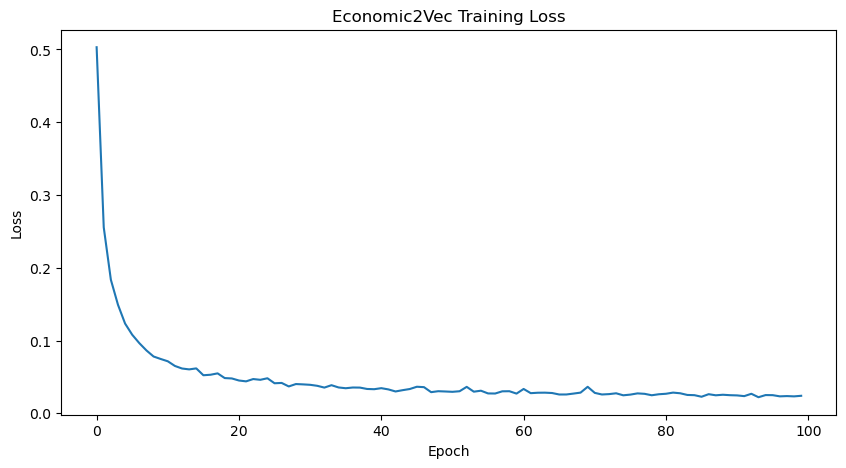


Method Comparisons:
Economic2Vec vs PCA correlation: 0.826


In [14]:
results, similarity_matrices, models_data = run_analysis_pipeline(df, scaled_data)


Plotting evaluation metrics comparison...


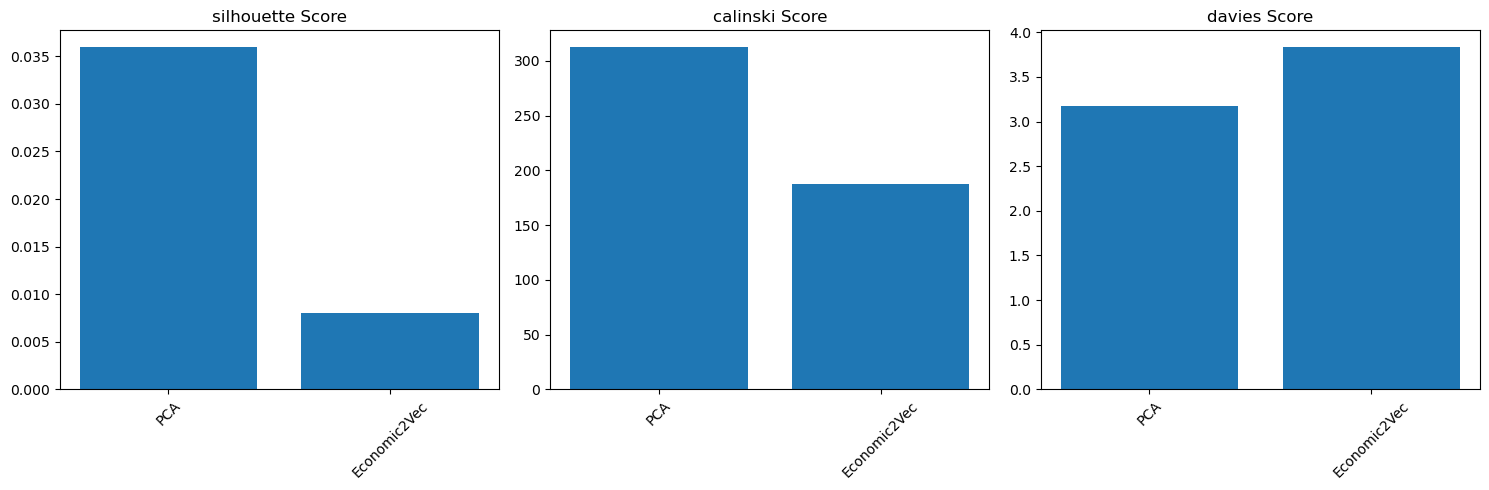


Plotting country similarity matrices...


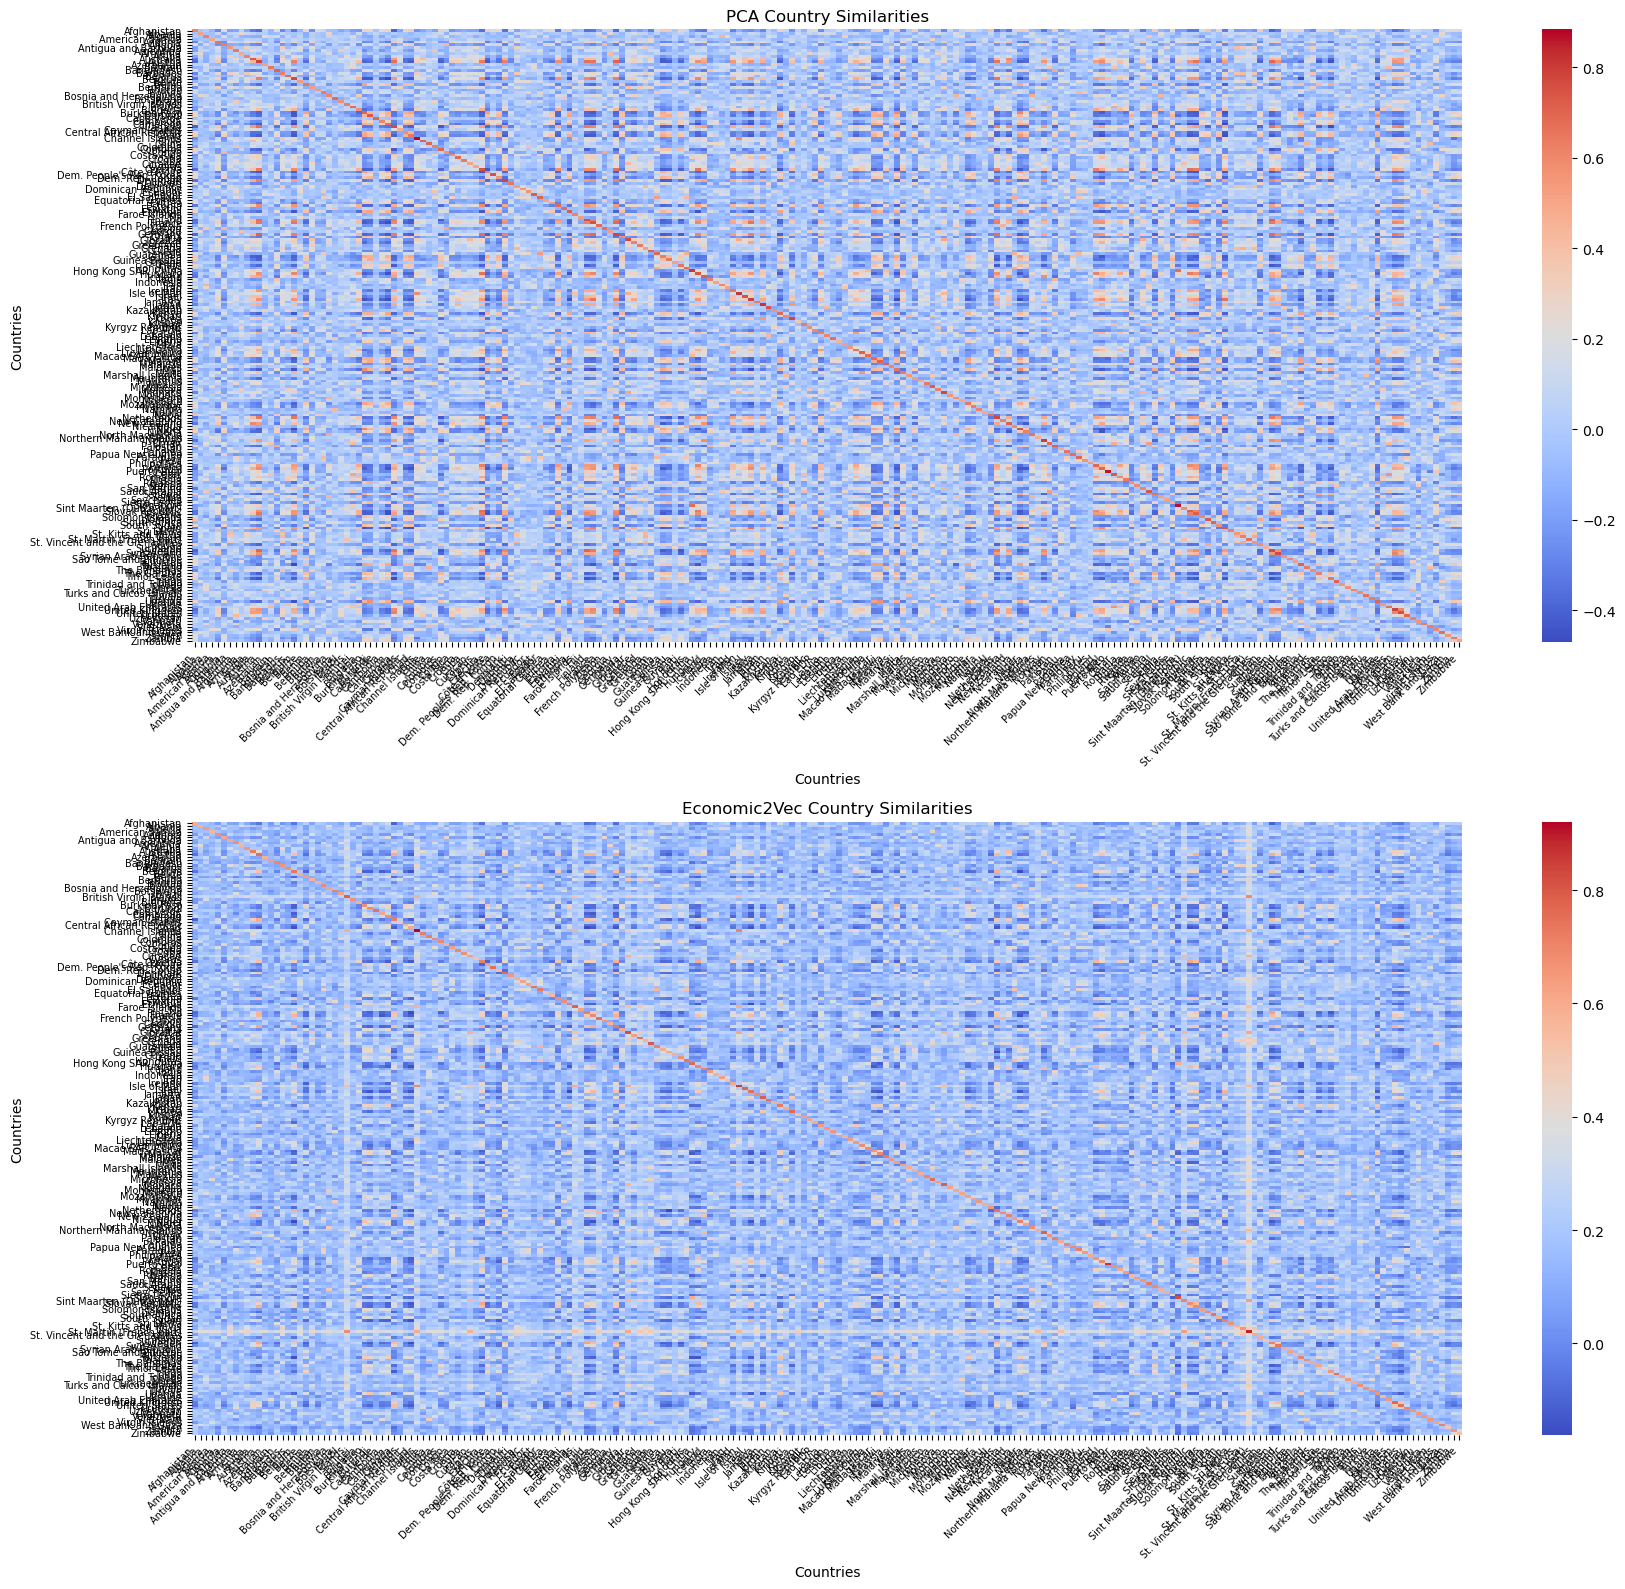


Top 5 most similar country pairs for each method:

PCA:
Germany - Sweden: 0.679
France - Germany: 0.689
Austria - Sweden: 0.695
Austria - Germany: 0.706
Finland - Sweden: 0.708

Economic2Vec:
Czechia - Slovak Republic: 0.616
Finland - Sweden: 0.623
Sint Maarten (Dutch part) - St. Martin (French part): 0.636
British Virgin Islands - St. Martin (French part): 0.691
Channel Islands - Isle of Man: 0.698

Processing PCA...

Creating 3D visualization for PCA...


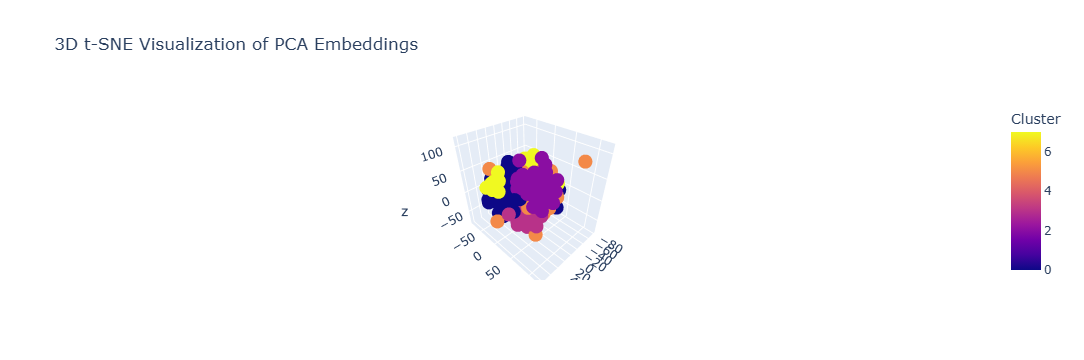


Cluster sizes for PCA:
0    43
1    35
2    38
3    20
4    15
5    51
6     4
7    11
Name: count, dtype: int64

Sample of gemini pairs for PCA:


NameError: name 'gemini_df' is not defined

In [26]:
run_complete_analysis(results, similarity_matrices, models_data, df)

## comare methods

## compare clustering

In [16]:
def compare_embedding_methods(results: Dict[str, Any], 
                            similarity_matrices: Dict[str, np.ndarray],
                            models_data: Dict[str, Dict]) -> Dict[str, str]:
    """
    Compare PCA and Economic2Vec embeddings using multiple metrics.
    Returns a dictionary with conclusions about which method performs better for each metric.
    """
    comparisons = {}
    
    # 1. Clustering Quality Metrics
    for metric in ['silhouette', 'calinski', 'davies']:
        pca_score = results['PCA'][metric]
        e2v_score = results['Economic2Vec'][metric]
        
        # Note: For davies_bouldin, lower is better
        if metric == 'davies':
            better = 'PCA' if pca_score < e2v_score else 'Economic2Vec'
        else:
            better = 'PCA' if pca_score > e2v_score else 'Economic2Vec'
            
        comparisons[f'{metric}_score'] = {
            'better_method': better,
            'PCA_score': pca_score,
            'E2V_score': e2v_score,
            'difference': abs(pca_score - e2v_score)
        }

    # 2. Similarity Matrix Properties
    for metric in ['similarity_mean', 'similarity_std', 'similarity_sparsity']:
        pca_value = results['PCA'][metric]
        e2v_value = results['Economic2Vec'][metric]
        
        comparisons[f'{metric}'] = {
            'PCA_value': pca_value,
            'E2V_value': e2v_value,
            'difference': abs(pca_value - e2v_value)
        }

    # 3. Correlation between methods
    correlation, _ = spearmanr(
        similarity_matrices['PCA'].flatten(),
        similarity_matrices['Economic2Vec'].flatten()
    )
    comparisons['method_correlation'] = correlation

    # Print detailed comparison
    print("\nDetailed Method Comparison:")
    print("-" * 50)
    
    print("\n1. Clustering Quality Metrics (higher is better except davies):")
    for metric in ['silhouette', 'calinski', 'davies']:
        comp = comparisons[f'{metric}_score']
        print(f"\n{metric.capitalize()} Score:")
        print(f"PCA: {comp['PCA_score']:.4f}")
        print(f"Economic2Vec: {comp['E2V_score']:.4f}")
        print(f"Better method: {comp['better_method']}")
        print(f"Difference: {comp['difference']:.4f}")

    print("\n2. Similarity Matrix Properties:")
    for metric in ['similarity_mean', 'similarity_std', 'similarity_sparsity']:
        comp = comparisons[metric]
        print(f"\n{metric.replace('_', ' ').capitalize()}:")
        print(f"PCA: {comp['PCA_value']:.4f}")
        print(f"Economic2Vec: {comp['E2V_value']:.4f}")
        print(f"Difference: {comp['difference']:.4f}")

    print(f"\n3. Method Correlation: {correlation:.4f}")
    print("\nThis indicates the degree to which both methods agree on country similarities")

    # Overall assessment
    print("\nOverall Assessment:")
    clustering_metrics = ['silhouette_score', 'calinski_score', 'davies_score']
    pca_wins = sum(1 for m in clustering_metrics if comparisons[m]['better_method'] == 'PCA')
    e2v_wins = sum(1 for m in clustering_metrics if comparisons[m]['better_method'] == 'Economic2Vec')
    
    if pca_wins > e2v_wins:
        print("PCA shows better overall clustering performance")
    elif e2v_wins > pca_wins:
        print("Economic2Vec shows better overall clustering performance")
    else:
        print("Both methods show comparable performance")

    return comparisons

In [32]:
# Compare the methods
comparison_results = compare_embedding_methods(results, similarity_matrices, models_data)


Detailed Method Comparison:
--------------------------------------------------

1. Clustering Quality Metrics (higher is better except davies):

Silhouette Score:
PCA: 0.0359
Economic2Vec: 0.0080
Better method: PCA
Difference: 0.0279

Calinski Score:
PCA: 312.1871
Economic2Vec: 187.4398
Better method: PCA
Difference: 124.7473

Davies Score:
PCA: 3.1689
Economic2Vec: 3.8301
Better method: PCA
Difference: 0.6613

2. Similarity Matrix Properties:

Similarity mean:
PCA: 0.0039
Economic2Vec: 0.1802
Difference: 0.1763

Similarity std:
PCA: 0.2123
Economic2Vec: 0.1375
Difference: 0.0748

Similarity sparsity:
PCA: 0.0224
Economic2Vec: 0.0176
Difference: 0.0048

3. Method Correlation: 0.8258

This indicates the degree to which both methods agree on country similarities

Overall Assessment:
PCA shows better overall clustering performance


## compare predictions

In [40]:
def evaluate_prediction_quality(embeddings: np.ndarray,
                              df: pd.DataFrame,
                              forecast_horizon: int = 1,
                              n_splits: int = 5) -> Dict[str, float]:
    """
    Evaluate embedding quality through prediction tasks with time series cross validation.
    """
    years = sorted(df['year'].unique())
    metrics = defaultdict(list)
    
    # Prepare data for prediction with year tracking
    X = []
    y = []
    year_indices = []  # Track which year each data point corresponds to
    
    # Create pairs of years for training
    for i in range(len(years) - forecast_horizon):
        current_year = years[i]
        future_year = years[i + forecast_horizon]
        
        current_mask = df['year'] == current_year
        future_mask = df['year'] == future_year
        
        current_embeddings = embeddings[current_mask]
        future_embeddings = embeddings[future_mask]
        
        X.append(current_embeddings)
        y.append(future_embeddings)
        year_indices.extend([i] * len(current_embeddings))
    
    X = np.vstack(X)
    y = np.vstack(y)
    year_indices = np.array(year_indices)
    
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train predictor
        predictor = Ridge()
        predictor.fit(X_train, y_train)
        
        # Make predictions
        y_pred = predictor.predict(X_test)
        
        # Calculate metrics for this fold
        metrics['mse'].append(mean_squared_error(y_test, y_pred))
        metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        
        # Calculate trajectory consistency for this fold
        fold_correlations = []
        
        # Get unique years in test set
        test_year_indices = year_indices[test_idx]
        test_years = [years[i] for i in np.unique(test_year_indices)]
        
        for country in df['country'].unique():
            # Get data for this country in test years
            country_data = []
            for year in test_years:
                mask = (df['country'] == country) & (df['year'] == year)
                if mask.any():
                    country_data.append(embeddings[mask][0])
            
            country_data = np.array(country_data)
            
            if len(country_data) > 2:
                changes = np.diff(country_data, axis=0)
                if len(changes) > 1:
                    corr = np.corrcoef(changes[:-1].flatten(), changes[1:].flatten())[0,1]
                    if not np.isnan(corr):
                        fold_correlations.append(corr)
        
        if fold_correlations:
            metrics['trajectory_consistency'].append(np.mean(fold_correlations))
    
    # Calculate final metrics
    final_metrics = {}
    for metric_name, values in metrics.items():
        if values:  # Only calculate if we have values
            final_metrics[f'{metric_name}_mean'] = np.mean(values)
            final_metrics[f'{metric_name}_std'] = np.std(values)
    
    return final_metrics

In [41]:
prediction_metrics = compare_prediction_quality(df, models_data)


Predictive Performance Comparison (with Cross-Validation):
--------------------------------------------------

PCA:
Mean Squared Error: 1.4229 (±1.2172)
Mean Absolute Error: 0.6219 (±0.2388)
Trajectory Consistency: -0.2973 (±0.0551)

Economic2Vec:
Mean Squared Error: 0.6805 (±0.4326)
Mean Absolute Error: 0.5250 (±0.1590)
Trajectory Consistency: -0.3005 (±0.0498)

Significance Testing:

MSE:
Difference is not significant
Better method: No clear winner

MAE:
Difference is not significant
Better method: No clear winner

TRAJECTORY_CONSISTENCY:
Difference is not significant
Better method: No clear winner
